# Twitter users gender classification

Schloesing Benjamin, Yao Yuan, Ramet Gaétan

## Introduction

The objective of this project is to find features which can help to determine a Twitter user's gender using machine learning.

## Step 1 : Import data

The dataset we will use is the [Twitter User Gender Classification](https://www.kaggle.com/crowdflower/twitter-user-gender-classification) dataset made available by [Crowdflower](https://www.crowdflower.com/). This datasets contains 20000 entries, each of them being a tweet from different users, with many other associated features which are listed here:

* **_unit_id** : a unique id for each user
* **_golden** : a boolean which states whether the user is included in the golden standard for the model
* **_unit_state** : the state of the obervation, eiter *golden* for gold standards or *finalized* for contributor-judged
* **_trusted_judgments** : the number of judgment on a user's gender. 3 for non-golden, or a unique id for golden
* **_last_judgment_at** : date and time of the last judgment, blank for golden observations
* **gender** : either *male*, *female* or *brand* for non-human profiles
* **gender:confidence** : a float representing the confidence of the gender judgment
* **profile_yn** : either *yes* or *no*, *no* meaning that the user's profile was not available when contributors went to judge it
* **profile_yn:confidence** : confidence in the existence/non-existence of the profile
* **created** : date and time of when the profile was created
* **description** : the user's Tweeter profile description
* **fav_number** : the amount of favorited tweets by the user
* **gender_gold** : the gender if the profile is golden
* **link_color** : the link color of the profile as a hex value
* **name** : the Tweeter user's name
* **profile_yn_gold** : *yes* or *no* whether the profile y/n value is golden
* **profileimage** : a link to the profile image
* **retweet_count** : the number of times the user has retweeted something
* **sidebar_color** : color of the profile sidebar as a hex value
* **text** : text of a random tweet from the user
* **tweet_coord** : if the location was available at the time of the tweet, the coordinates as a string ith the format[latitude, longitude]
* **tweet_count** : number of tweet of the users
* **tweet_created** : the time of the random tweet in **text**
* **tweet_id** : the tweet id of the random tweet
* **tweet_location** : the location of the tweet, based on the coordinates
* **user_timezone** : the timezone of the user

Most of these features are not relevant for our analysis, we will only focus on a few of them

In [10]:
import pandas as pd
import numpy as np

# we need latin-1 encoding because there are some special characters (é,...) that do not fit in default UTF-8
dataFrame = pd.read_csv('gender-classifier-DFE-791531.csv', encoding='latin-1')

#Show a sample of the dataset
dataFrame.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,...,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/5/13 1:48,...,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/1/12 13:51,...,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,ÛÏIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada)
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,...,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,10/26/15 12:40,6.587300e+17,clcncl,Belgrade
3,815719229,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0,6/11/09 22:39,...,https://pbs.twimg.com/profile_images/259703936...,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,NaN,1693,10/26/15 12:40,6.587300e+17,"Palo Alto, CA",Pacific Time (US & Canada)
4,815719230,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0,4/16/14 13:23,...,https://pbs.twimg.com/profile_images/564094871...,0,0,Watching Neighbours on Sky+ catching up with t...,NaN,31462,10/26/15 12:40,6.587300e+17,NaN,NaN


In [23]:
dataFrame.loc[:1,['name']]
# Normalize text in the descriptions and tweet messages
import re

def text_normalizer(s):
    #we will normalize the text by using strings, lowercases and removing all the punctuations
    s = str(s) 
    s = s.lower()
    s = re.sub('\W\s',' ',s)
    s = re.sub('\s\W',' ',s)
    s = re.sub('\s+',' ',s) #replace double spaces with single spaces
    
    return s
dataFrame['text_norm'] = [text_normalizer(s) for s in dataFrame['text']]
dataFrame['description_norm'] = [text_normalizer(s) for s in dataFrame['description']]

# Extract separate genders dataframes
male_data = dataFrame[(dataFrame['gender']=='male')&(dataFrame['gender:confidence']==1)]
female_data = dataFrame[(dataFrame['gender']=='female')&(dataFrame['gender:confidence']==1)]
brand_data = dataFrame[(dataFrame['gender']=='brand')&(dataFrame['gender:confidence']==1)]
male_data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,...,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone,text_norm,description_norm
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0,yes,1.0,12/5/13 1:48,...,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai,robbie e responds to critics after win against...,i sing my own rhythm.
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0,yes,1.0,10/1/12 13:51,...,C0DEED,ÛÏIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada),ûïit felt like they were my friends and i was...,i'm the author of novels filled with family dr...
3,815719229,False,finalized,3,10/26/15 23:10,male,1.0,yes,1.0,6/11/09 22:39,...,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,NaN,1693,10/26/15 12:40,6.587300e+17,"Palo Alto, CA",Pacific Time (US & Canada),hi jordanspieth looking at the url do you use ...,mobile guy 49ers shazam google kleiner perkins...
7,815719233,False,finalized,3,10/26/15 23:48,male,1.0,yes,1.0,12/3/12 21:54,...,C0DEED,Gala Bingo clubs bought for å£241m: The UK's l...,NaN,112117,10/26/15 12:40,6.587300e+17,NaN,NaN,gala bingo clubs bought for å£241m the uk's la...,the secret of getting ahead is getting started.
17,815719243,False,finalized,3,10/26/15 22:50,male,1.0,yes,1.0,10/18/09 11:41,...,C0DEED,@coolyazzy94 Ditto - I'm still learning the fa...,NaN,91,10/26/15 12:40,6.587300e+17,Glasgow,London,@coolyazzy94 ditto i'm still learning the favo...,over enthusiastic f1 fan model collector music...


In [200]:
#Exploration of which words are most used by which gender
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display

def compute_bag_of_words(text):
    vectorizer = CountVectorizer()
    vectors = vectorizer.fit_transform(text)
    vocabulary = vectorizer.get_feature_names()
    return vectors, vocabulary

def print_most_frequent(bow, vocab, n=20):
    idx = np.argsort(bow.sum(axis=0))
    for i in range(1,n+1):
        j = idx[0, -i]
        print(vocab[j])

male_bow, male_voc = compute_bag_of_words(male_data['description_norm'])

most_used_idx = np.argsort(male_bow.sum(axis=0))
# most_used_words = [male_voc[most_used_idx[0,j]] for j in range(-1,-20)]
for j in range(1,20):
    most_used_words[j] = male_voc[most_used_idx[0,-j]]
print(most_used_words[:5])
print_most_frequent(male_bow, male_voc)
#nothing special about these words really
print('---')
female_bow, female_voc = compute_bag_of_words(female_data['description_norm'])

print_most_frequent(female_bow, female_voc)
#nothing special about these words really
print('---')

brand_bow, brand_voc = compute_bag_of_words(brand_data['description_norm'])

print_most_frequent(brand_bow, brand_voc)
#nothing special about these words really

IndexError: list assignment index out of range

Split: 2760 testing and 11044 training samples
Testing Ridge Classifier model:
mse: 0.5022
score:  0.68152173913
Best 20 male predictors:


<IPython.core.display.Javascript object>


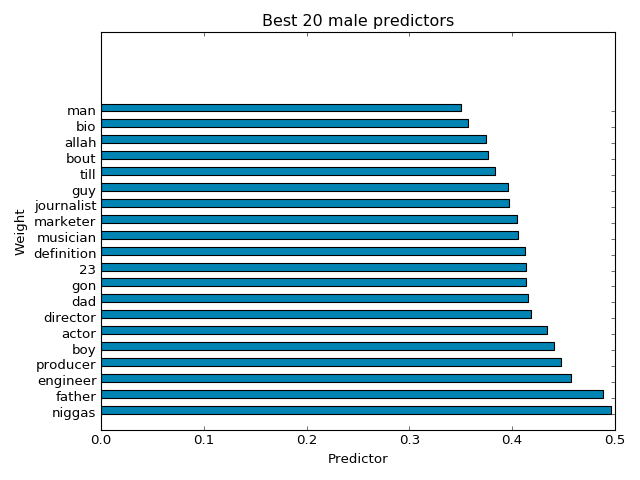

Best 20 male anti-predictors:


<IPython.core.display.Javascript object>


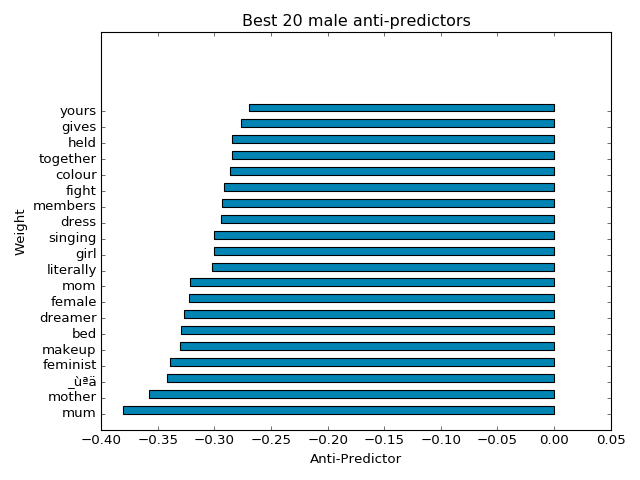

Best 20 female predictors:


<IPython.core.display.Javascript object>


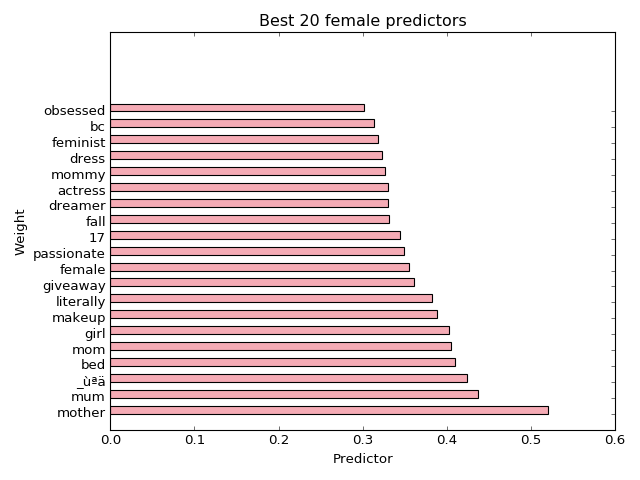

Best 20 female anti-predictors:


<IPython.core.display.Javascript object>


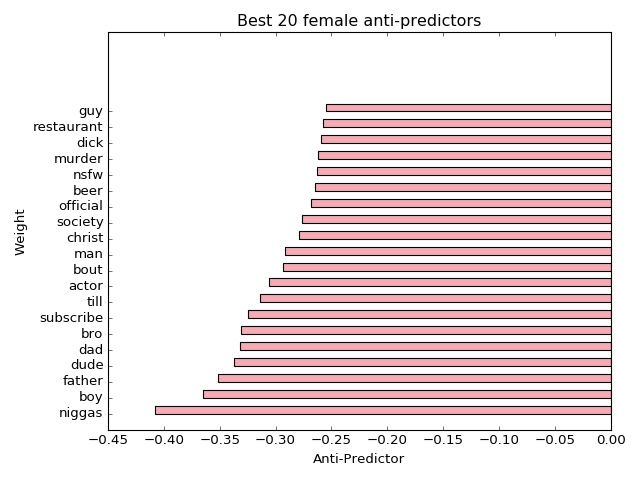

Best 20 brand predictors:


<IPython.core.display.Javascript object>


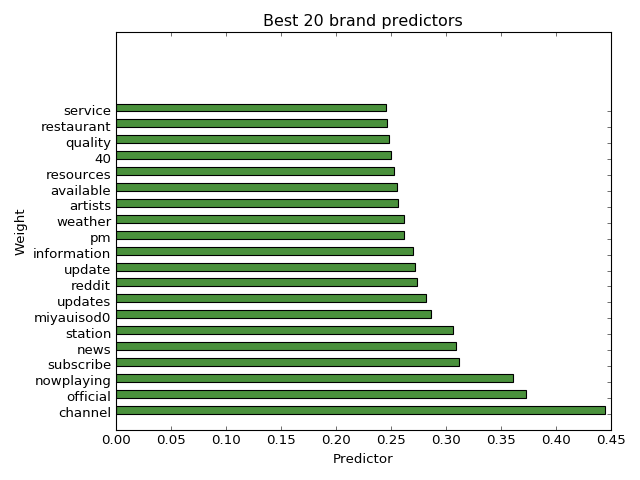

Best 20 brand anti-predictors:


<IPython.core.display.Javascript object>


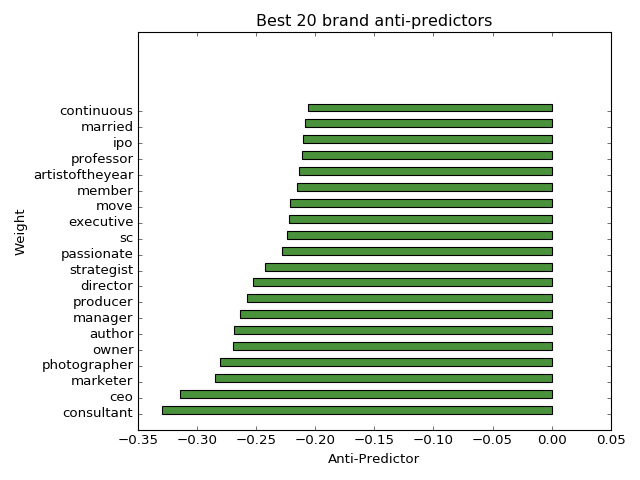

In [184]:
#Looking at the most used words per gender doesnt yield anything particular since we all use the same common words,
#so let's try to find predictors

#first let's put all the interesting text in one string for each tweet
dataFrame['all_text'] =dataFrame['text_norm'].str.cat(dataFrame['description_norm'],sep=' ')
dataFrameConf = dataFrame[(dataFrame['gender:confidence']==1)&(dataFrame['gender']!='unknown')]

from sklearn.preprocessing import LabelEncoder

full_bow, full_voc = compute_bag_of_words(dataFrameConf['all_text'])
X = full_bow
y = LabelEncoder().fit_transform(dataFrameConf['gender'])
# Encoder : 2 = male, 1 = female, 0 = brand

# Create Training and testing sets.
n,d = X.shape
test_size = n // 5
print('Split: {} testing and {} training samples'.format(test_size, y.size - test_size))
perm = np.random.permutation(y.size)
X_test  = X[perm[:test_size]]
X_train = X[perm[test_size:]]
y_test  = y[perm[:test_size]]
y_train = y[perm[test_size:]]

# Linear model regression
from sklearn import linear_model, metrics

%matplotlib notebook 
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import ndimage

def model_test(model,X_train,y_train,X_test,y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    mse = metrics.mean_squared_error(y_test,y_pred)
    print('mse: {:.4f}'.format(mse))

    W = model.coef_
    print('score: ', model.score(X_test,y_test))
# Male Predictors 
    print('Best 20 male predictors:')
    idx_male = np.argsort((W[2,:]))
    weight_male_pred = np.zeros(20)
    male_pred_label = ["" for x in range(20)]
    for i in range(20):
        j = idx_male[-1-i]
        weight_male_pred[i] = W[2,j]
        male_pred_label[i] = full_voc[j]

    fig1, ax1 = plt.subplots()

    bar_width = 0.5
    pred_number = np.arange(20)+1
    rects1 = plt.barh(pred_number,weight_male_pred, bar_width, label = 'Male Predictors', color = '#0084b4')
    plt.yticks(pred_number,male_pred_label)
    plt.xlabel('Predictor')
    plt.ylabel('Weight')
    plt.title('Best 20 male predictors')
    plt.tight_layout()
    plt.show()
# Male Anti-Predictors    
    print('Best 20 male anti-predictors:')
    idx_male = np.argsort(-(W[2,:]))
    weight_male_antipred = np.zeros(20)
    male_antipred_label = ["" for x in range(20)]
    for i in range(20):
        j = idx_male[-1-i]
        weight_male_antipred[i] = W[2,j]
        male_antipred_label[i] = full_voc[j]

    fig2, ax2 = plt.subplots()

    bar_width = 0.5
    pred_number = np.arange(20)+1
    rects1 = plt.barh(pred_number,weight_male_antipred, bar_width, label = 'Male Anti-Predictors', color = '#0084b4')
    plt.yticks(pred_number,male_antipred_label)
    plt.xlabel('Anti-Predictor')
    plt.ylabel('Weight')
    plt.title('Best 20 male anti-predictors')
    plt.tight_layout()
    plt.show()
# Female Predictors    
    print('Best 20 female predictors:')
    idx_female = np.argsort((W[1,:]))
    weight_female_pred = np.zeros(20)
    female_pred_label = ["" for x in range(20)]
    for i in range(20):
        j = idx_female[-1-i]
        weight_female_pred[i] = W[1,j]
        female_pred_label[i] = full_voc[j]

    fig3, ax3 = plt.subplots()

    bar_width = 0.5
    pred_number = np.arange(20)+1
    rects1 = plt.barh(pred_number,weight_female_pred, bar_width, label = 'Female Predictors', color = '#f5abb5')
    plt.yticks(pred_number,female_pred_label)
    plt.xlabel('Predictor')
    plt.ylabel('Weight')
    plt.title('Best 20 female predictors')
    plt.tight_layout()
    plt.show()
# Female Anti-Predictors    
    print('Best 20 female anti-predictors:')
    idx_female = np.argsort(-(W[1,:]))
    weight_female_antipred = np.zeros(20)
    female_antipred_label = ["" for x in range(20)]
    for i in range(20):
        j = idx_female[-1-i]
        weight_female_antipred[i] = W[1,j]
        female_antipred_label[i] = full_voc[j]

    fig4, ax4 = plt.subplots()

    bar_width = 0.5
    pred_number = np.arange(20)+1
    rects1 = plt.barh(pred_number,weight_female_antipred, bar_width, label = 'Female Anti-Predictors', color = '#f5abb5')
    plt.yticks(pred_number,female_antipred_label)
    plt.xlabel('Anti-Predictor')
    plt.ylabel('Weight')
    plt.title('Best 20 female anti-predictors')
    plt.tight_layout()
    plt.show()
# Brand Predictors    
    print('Best 20 brand predictors:')
    idx_brand = np.argsort((W[0,:]))
    weight_brand_pred = np.zeros(20)
    brand_pred_label = ["" for x in range(20)]
    for i in range(20):
        j = idx_brand[-1-i]
        weight_brand_pred[i] = W[0,j]
        brand_pred_label[i] = full_voc[j]

    fig5, ax5 = plt.subplots()

    bar_width = 0.5
    pred_number = np.arange(20)+1
    rects1 = plt.barh(pred_number,weight_brand_pred, bar_width, label = 'Brand Predictors', color = '#4a913c')
    plt.yticks(pred_number,brand_pred_label)
    plt.xlabel('Predictor')
    plt.ylabel('Weight')
    plt.title('Best 20 brand predictors')
    plt.tight_layout()
    plt.show()
# Brand Anti-Predictors    
    print('Best 20 brand anti-predictors:')
    idx_brand = np.argsort(-(W[0,:]))
    weight_brand_antipred = np.zeros(20)
    brand_antipred_label = ["" for x in range(20)]
    for i in range(20):
        j = idx_brand[-1-i]
        weight_brand_antipred[i] = W[0,j]
        brand_antipred_label[i] = full_voc[j]

    fig6, ax6 = plt.subplots()

    bar_width = 0.5
    pred_number = np.arange(20)+1
    rects1 = plt.barh(pred_number,weight_brand_antipred, bar_width, label = 'Brand Anti-Predictors', color = '#4a913c')
    plt.yticks(pred_number,brand_antipred_label)
    plt.xlabel('Anti-Predictor')
    plt.ylabel('Weight')
    plt.title('Best 20 brand anti-predictors')
    plt.tight_layout()
    plt.show()    

model = linear_model.RidgeClassifier()
print('Testing Ridge Classifier model:')
model_test(model,X_train,y_train,X_test,y_test)


Testing Passive Aggressive classifier model:
mse: 0.5373
score:  0.664855072464
Best 20 male predictors:


<IPython.core.display.Javascript object>


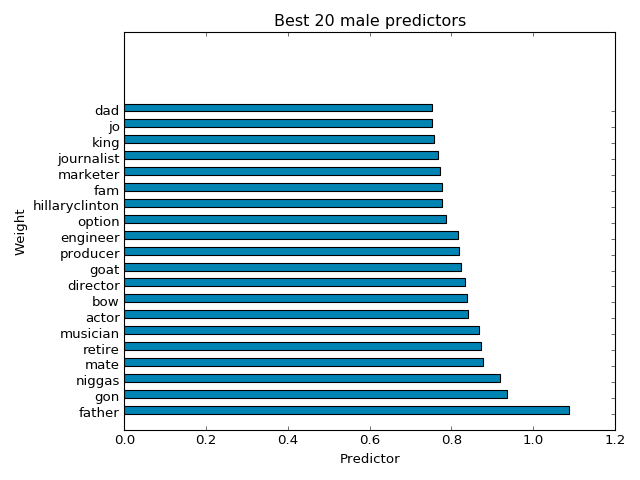

Best 20 male anti-predictors:


<IPython.core.display.Javascript object>


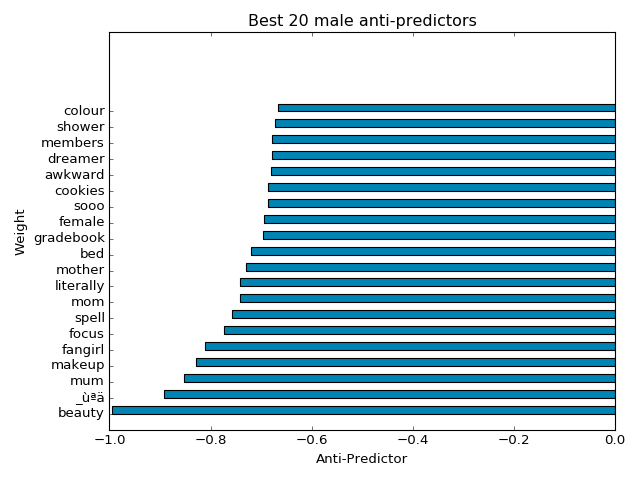

Best 20 female predictors:


<IPython.core.display.Javascript object>


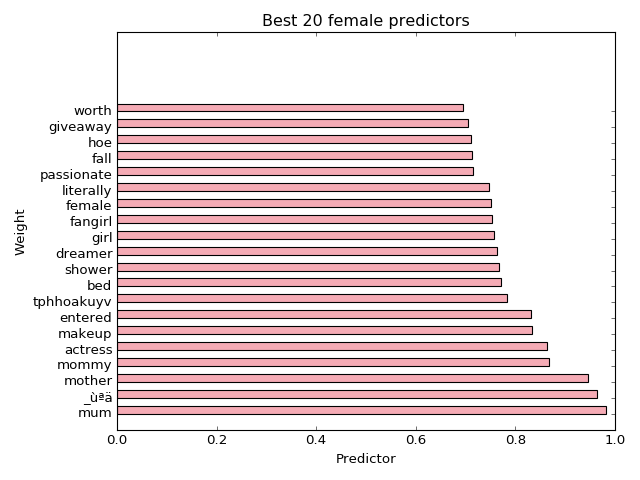

Best 20 female anti-predictors:


<IPython.core.display.Javascript object>


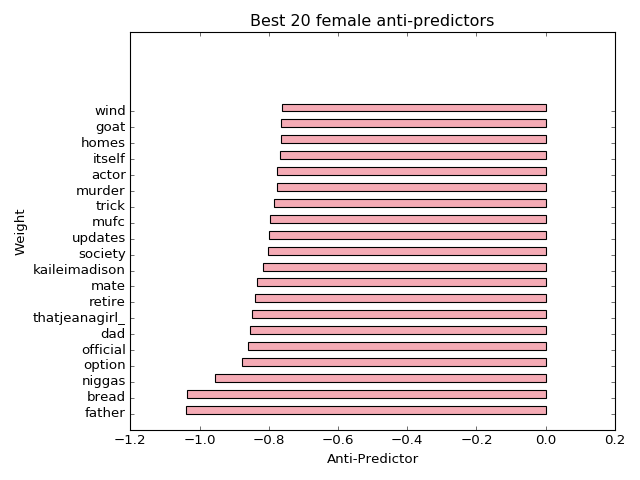

Best 20 brand predictors:


<IPython.core.display.Javascript object>


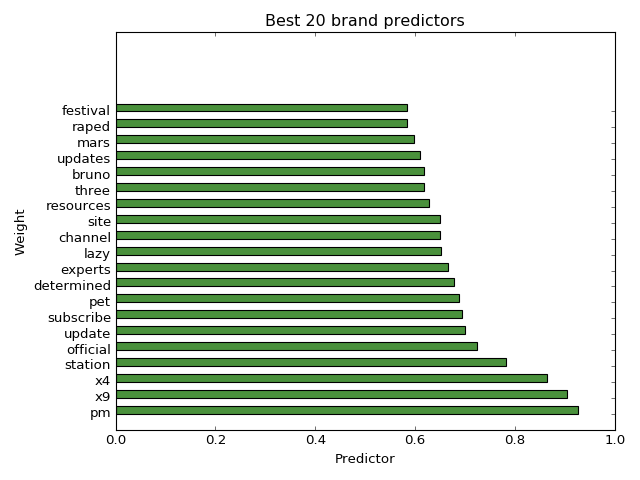

Best 20 brand anti-predictors:


<IPython.core.display.Javascript object>


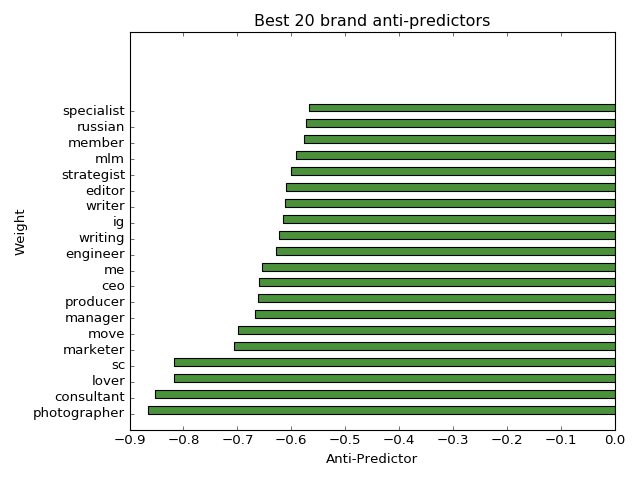

In [185]:
model = linear_model.PassiveAggressiveClassifier()
print('Testing Passive Aggressive classifier model:')
model_test(model,X_train,y_train,X_test,y_test)

Testing SGD classifier model:
mse: 0.5511
score:  0.645652173913
Best 20 male predictors:


<IPython.core.display.Javascript object>


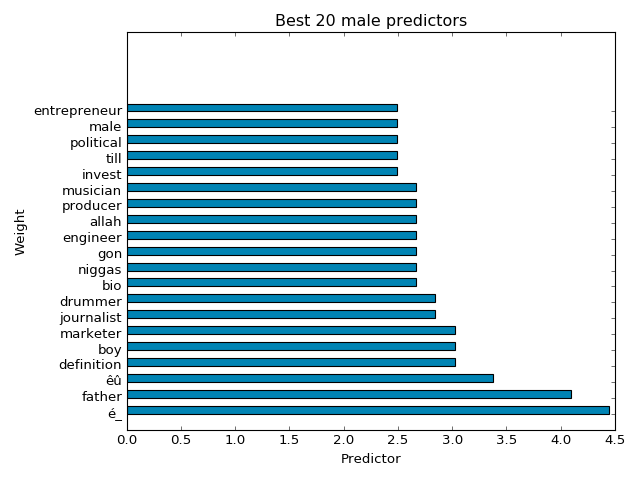

Best 20 male anti-predictors:


<IPython.core.display.Javascript object>


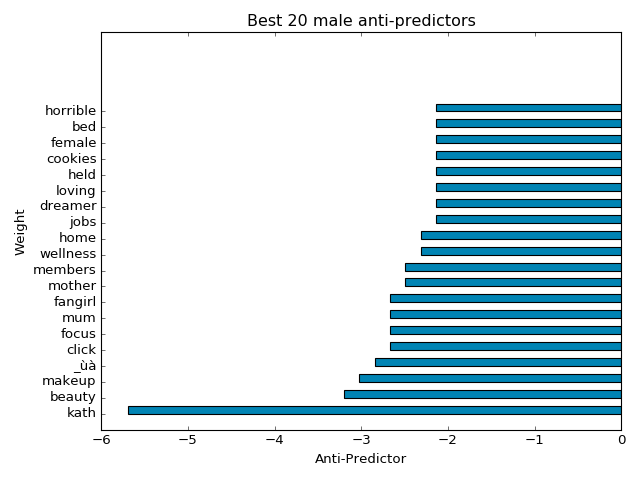

Best 20 female predictors:


<IPython.core.display.Javascript object>


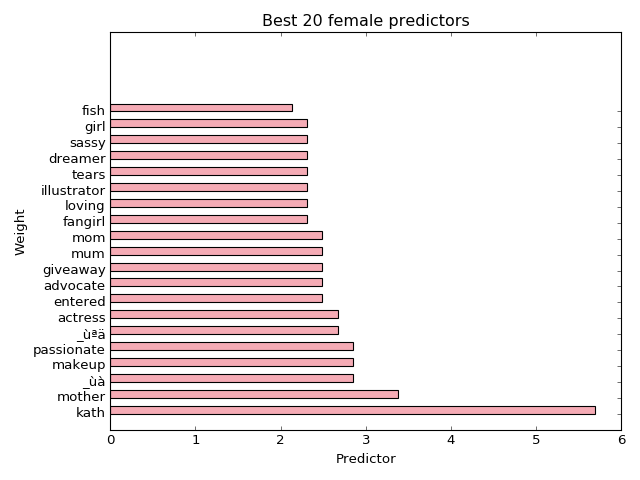

Best 20 female anti-predictors:


<IPython.core.display.Javascript object>


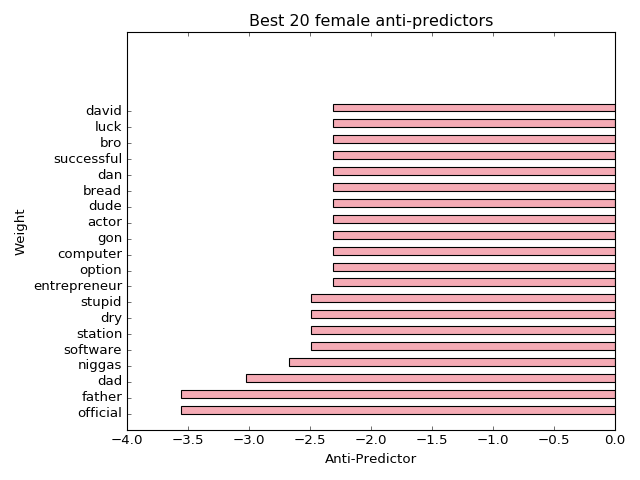

Best 20 brand predictors:


<IPython.core.display.Javascript object>


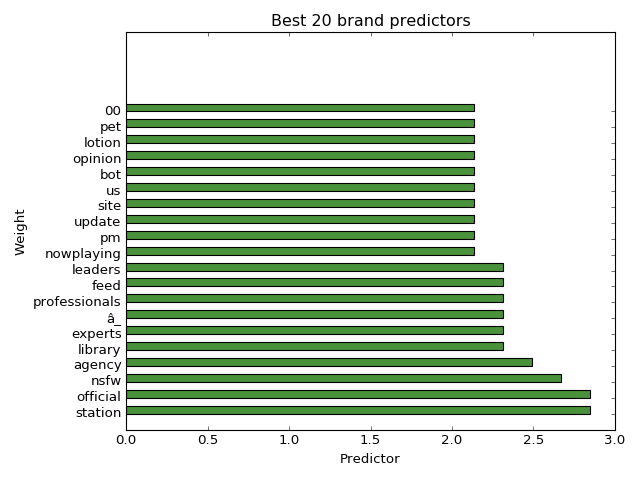

Best 20 brand anti-predictors:


<IPython.core.display.Javascript object>


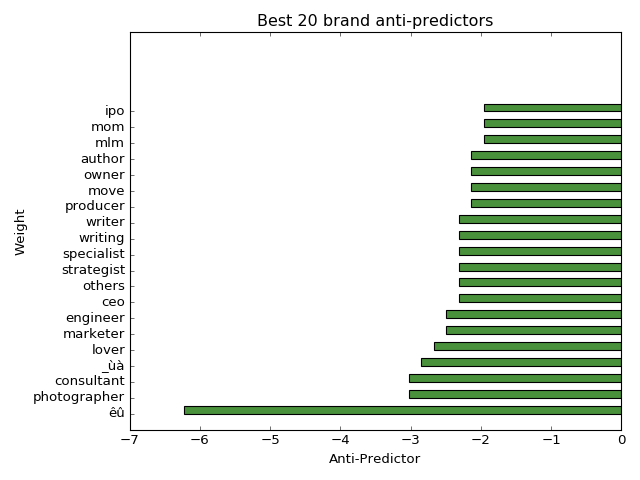

In [187]:
model = linear_model.SGDClassifier()
print('Testing SGD classifier model:')
model_test(model,X_train,y_train,X_test,y_test)

Testing Logistic Regression model:
mse: 0.4909
score:  0.685144927536
Best 20 male predictors:


<IPython.core.display.Javascript object>


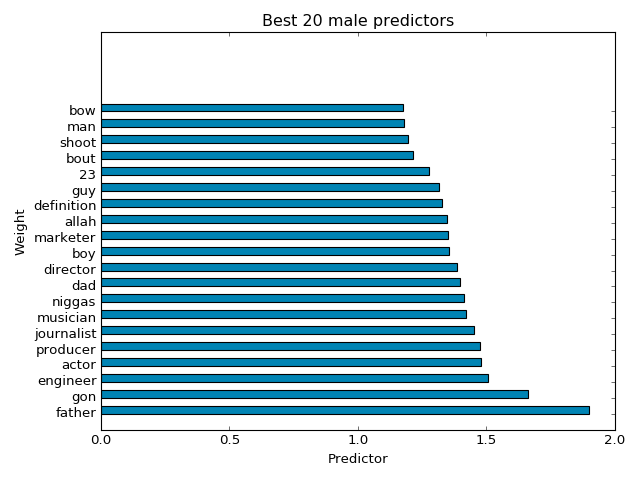

Best 20 male anti-predictors:


<IPython.core.display.Javascript object>


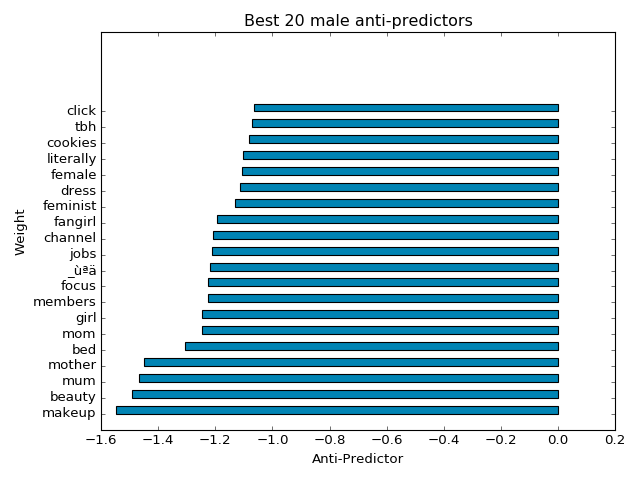

Best 20 female predictors:


<IPython.core.display.Javascript object>


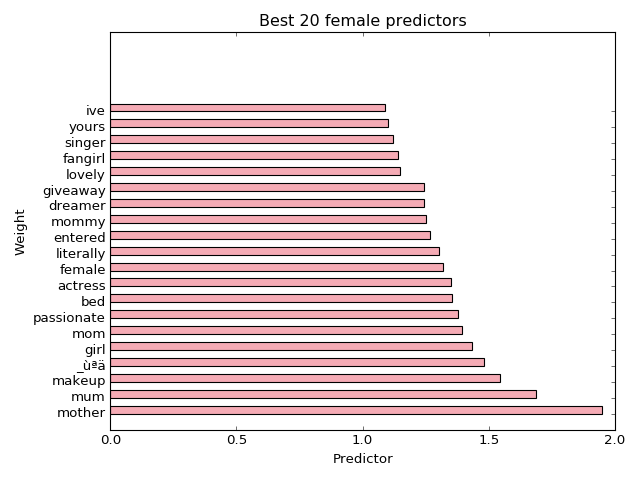

Best 20 female anti-predictors:


<IPython.core.display.Javascript object>


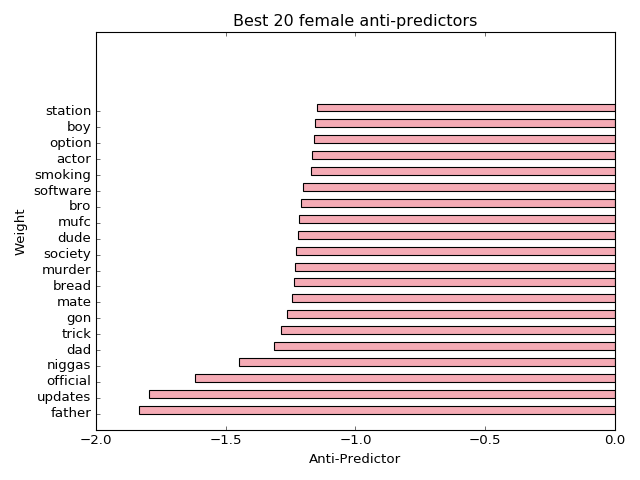

Best 20 brand predictors:


<IPython.core.display.Javascript object>


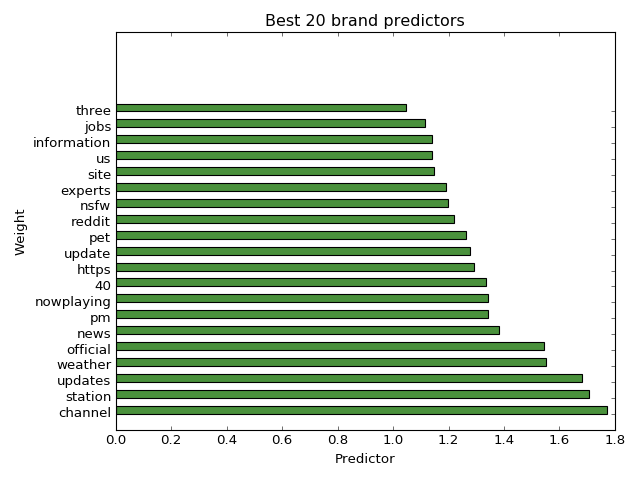

Best 20 brand anti-predictors:


<IPython.core.display.Javascript object>


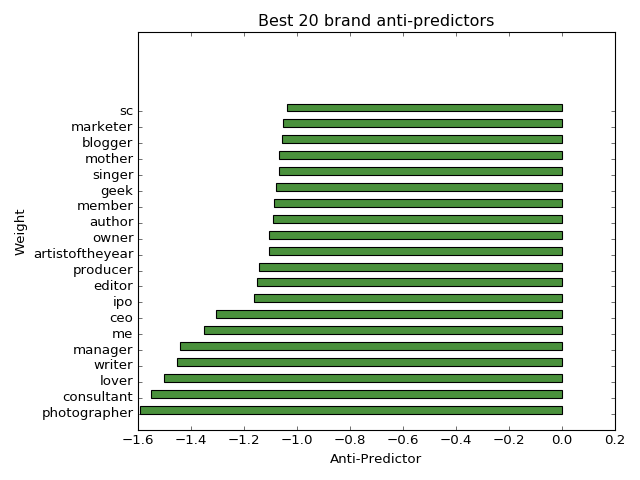

In [186]:
model = linear_model.LogisticRegression()
print('Testing Logistic Regression model:')
model_test(model,X_train,y_train,X_test,y_test)